In [1]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

2024-08-11 16:41:13.610953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-11 16:41:13.613883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-11 16:41:13.623465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 16:41:13.641208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 16:41:13.647698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 16:41:13.659344: I tensorflow/core/platform/cpu_feature_gu

### Example 1: Predict the tag for a Stack Overflow question

#### Download and explore the dataset

In [2]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/"\
    "data/stack_overflow_16k.tar.gz"

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir="./work/stack_overflow",
    cache_subdir=""
)

dataset_dir = pathlib.Path(dataset_dir).parent

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/train')]

In [4]:
train_dir = dataset_dir / "train"
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/csharp')]

In [5]:
sample_file = train_dir / "python" / "1755.txt"

with open(sample_file) as f:
    print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



#### Load the dataset

In [6]:
batch_size = 32
seed = 42

# Create a validation dataset by using an 80:20 split of the training dataset
raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2024-08-11 16:41:46.897382: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

2024-08-11 16:41:55.182142: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
for i, label in enumerate(raw_train_ds.class_names):
    print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
# Create a validation dataset
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
test_dir = dataset_dir / "test"

# Create a test dataset
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


#### Configure the datasets for performance

In [11]:
# Data prefetching and caching in memory
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

#### Prepare the dataset for training

In [12]:
VOCAB_SIZE = 10000

# Vectorization for bag-of-words model
binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="binary"
)

In [13]:
MAX_SEQUENCE_LENGTH = 250

# Vectorization for 1-d ConvNet
int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [14]:
# Vectorize text-only dataset (without labels)
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

2024-08-11 16:42:34.406742: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    pub

"binary" vectorized question: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

(0.0, 1000.0)

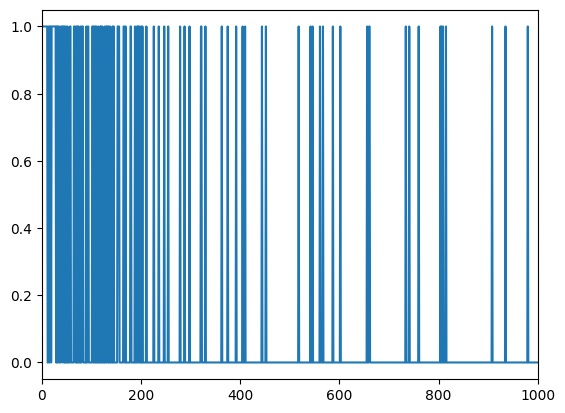

In [16]:
print(
    '"binary" vectorized question:',
    list(binary_vectorize_layer(first_question).numpy())
)

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0, 1000)

In [17]:
print(
    '"int" vectorized question:',
    int_vectorize_layer(first_question).numpy()
)

"int" vectorized question: [   1  111    6   23  299 1787  198    2 3623  299 7826    1    1  805
 2568   23    1 1218 3892  364 4145    1    1  661   16    5  981   45
  121 1881   47    1  742   36 9987    8 1982  322  662   36   23 2362
  195  543   83 2693 2609  661  144    1  411    2 1371   23  657    1
 6520   84   66    3  166  104   26 1182    6    5    1 1639   44    3
  189 3623  519 1135    1   44 5468  280 1272   71  156  157    5 1759
    9  331    3  227    2 3623  299  115  810    5  547 3833    3    1
 2371  146  202 1195  289    1    6 2179 1787  193    9  136 1195   45
    6   67  181    4   11  198  106    1    1  299   31    1 2216 1924
   29  299   53   28 2081   22   53   42  170  154  256    7   15  453
   28    1  237 2698    1  134 2698  131 2698  323 2698    1    1    1
    1    1    1   23    1 2216 1924   29  299   22   53   42  170  154
  256 1360   15  453   28  237    1  237   68    9  196  807   28 7167
    1  237    1 1364    1  562    1 4406  735 1820

In [18]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print(f"Vocabulary size: {len(int_vectorize_layer.get_vocabulary())}")

1289 --->  roman
313 --->  source
Vocabulary size: 10000


#### Train the model

In [19]:
binary_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    binary_vectorize_layer,
    layers.Dense(4)
])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

tf.keras.utils.plot_model(binary_model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10
)

print()

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5135 - loss: 1.2448 - val_accuracy: 0.7769 - val_loss: 0.9169
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8214 - loss: 0.8222 - val_accuracy: 0.7975 - val_loss: 0.7516
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8608 - loss: 0.6532 - val_accuracy: 0.8131 - val_loss: 0.6654
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8869 - loss: 0.5529 - val_accuracy: 0.8188 - val_loss: 0.6116
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9033 - loss: 0.4835 - val_accuracy: 0.8331 - val_loss: 0.5748
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9163 - loss: 0.4312 - val_accuracy: 0.8381 - val_loss: 0.5480
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9258 - loss: 0.3898 - val_accuracy: 0.8381 - val_loss: 0.5279
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9332 - loss: 0.3557 - va

In [25]:
# Create a 1-d ConvNet
def create_model(vocab_size, num_labels, vectorizer=None):
    my_layers = [layers.Input(shape=(1,), dtype=tf.string)]
    if vectorizer is not None:
        my_layers.extend([vectorizer])

    my_layers.extend([
        layers.Embedding(vocab_size, 64, mask_zero=True),
        layers.Dropout(0.5),
        layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(num_labels)
    ])

    model = tf.keras.Sequential(my_layers)
    return model

In [26]:
# Use the size (VOCAB_SIZE + 1) since "9" is used additionally for padding
int_model = create_model(
    vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer
)

tf.keras.utils.plot_model(int_model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [27]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3385 - loss: 1.3420 - val_accuracy: 0.6356 - val_loss: 0.8893
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6481 - loss: 0.8357 - val_accuracy: 0.7575 - val_loss: 0.6346
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7714 - loss: 0.5981 - val_accuracy: 0.8069 - val_loss: 0.5482
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8442 - loss: 0.4466 - val_accuracy: 0.8200 - val_loss: 0.5016
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8994 - loss: 0.3300 - val_accuracy: 0.8219 - val_loss: 0.4927
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9343 - loss: 0.2329 - val_accuracy: 0.8163 - val_loss: 0.5098
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9537 - loss: 0.1702 - val_accuracy: 0.8169 - val_loss: 0.5364
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9669 - loss: 0.1246 - val_accu

Text(0, 0.5, 'CE/token')

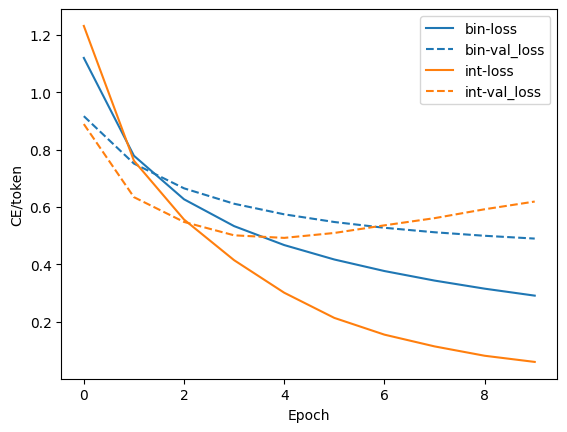

In [28]:
loss = plt.plot(
    bin_history.epoch, bin_history.history["loss"], label="bin-loss"
)
plt.plot(
    bin_history.epoch, bin_history.history["val_loss"],
    "--", color=loss[0].get_color(),
    label="bin-val_loss"
)

loss = plt.plot(
    int_history.epoch, int_history.history["loss"], label="int-loss"
)
plt.plot(
    int_history.epoch, int_history.history["val_loss"],
    "--", color=loss[0].get_color(),
    label="int-val_loss"
)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("CE/token")

In [29]:
# Apply the TextVectorization layer to the datasets
binary_train_ds = raw_train_ds.map(lambda x, y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x, y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x, y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x, y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x, y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x, y: (int_vectorize_layer(x), y))

#### Export the model

In [30]:
binary_model.export("./work/bin.tf")

INFO:tensorflow:Assets written to: ./work/bin.tf/assets


INFO:tensorflow:Assets written to: ./work/bin.tf/assets


Saved artifact at './work/bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.string, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139836559768848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139836559769232: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139836559760400: TensorSpec(shape=(), dtype=tf.string, name=None)
  139836559765200: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139836547205072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139836547207376: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
loaded = tf.saved_model.load("./work/bin.tf")

In [35]:
binary_model.predict(tf.constant(["How do you sort a list?"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


array([[-0.11697719,  0.00955971, -0.6200534 ,  0.37437475]],
      dtype=float32)

In [41]:
loaded.serve(tf.constant([["How do you sort a list?"]])).numpy()

array([[-0.11697719,  0.00955971, -0.6200534 ,  0.37437475]],
      dtype=float32)

### Example 2: Predict the author or lliad translations

#### Download and explore the dataset

In [42]:
DIRECTORY_URL = "https://storage.googleapis.com/download.tensorflow.org"\
    "/data/illiad/"
FILE_NAMES = ["cowper.txt", "derby.txt", "butler.txt"]

for name in FILE_NAMES:
    text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

815980/815980 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
809730/809730 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
807992/807992 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


[PosixPath('/home/dev/.keras/datasets/derby.txt'),
 PosixPath('/home/dev/.keras/datasets/cowper.txt'),
 PosixPath('/home/dev/.keras/datasets/butler.txt')]

#### Load the dataset

In [43]:
# Set a label to a sample in TextLineDataset
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [44]:
labeled_datasets = []

for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(str(parent_dir / file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_datasets.append(labeled_dataset)

In [45]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

# Concatenate all labeled dataset
all_labeled_data = labeled_datasets[0]
for labeled_dataset in labeled_datasets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

# Shuffle the dataset
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False
)

In [46]:
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label: ", label.numpy())

Sentence:  b"In vain with honey'd words, in vain with threats;"
Label:  1
Sentence:  b'\xc3\x86neas next two mightiest warriors slew,'
Label:  0
Sentence:  b'Respected, in convivial pleasures sweet'
Label:  0
Sentence:  b"He said; up sprang Oileus' active son,"
Label:  1
Sentence:  b'Parthenius, Cromna, Aegialus, and lofty Erithini.'
Label:  2
Sentence:  b"Prostrate he fell, and Meges stripp'd his arms."
Label:  0
Sentence:  b'ever. He was returning from Oechalia, where Eurytus lived and reigned,'
Label:  2
Sentence:  b'Thus Ajax; Teucer heard, and ran in haste,'
Label:  1
Sentence:  b'Idomeneus, the warlike bands of Crete'
Label:  1
Sentence:  b'Each slew a warrior. Agamemnon first'
Label:  0


2024-08-11 16:54:34.463670: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Prepare the dataset for training

In [81]:
# tokenizer = MyTokenizer()  # Not worked properly

# From JP tutorial after here
tokenizer = tf_text.UnicodeScriptTokenizer()

In [82]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

In [84]:
tokenized_ds = all_labeled_data.map(tokenize)
tokenized_ds

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [86]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'in' b'vain' b'with' b'honey' b"'" b'd' b'words' b',' b'in' b'vain'
 b'with' b'threats' b';']
Tokens:  [b'\xc3\xa6neas' b'next' b'two' b'mightiest' b'warriors' b'slew' b',']
Tokens:  [b'respected' b',' b'in' b'convivial' b'pleasures' b'sweet']
Tokens:  [b'he' b'said' b';' b'up' b'sprang' b'oileus' b"'" b'active' b'son' b',']
Tokens:  [b'parthenius' b',' b'cromna' b',' b'aegialus' b',' b'and' b'lofty'
 b'erithini' b'.']


In [87]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build a vocabulary: count tokens and sort them its frequency
vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)

Vocab size:  10000
First five vocab entries:  [b',', b'the', b'and', b"'", b'of']


2024-08-11 17:49:08.859926: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [88]:
keys = vocab
# Reserve "0" for padding, "1" for OOV (out-of-vocabulary) tokens
values = range(2, len(vocab) + 2)

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64
)

# Vocabulary table, for conversion from the tokens to integers 
num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [89]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [92]:
# Make a vocabulary table
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b"In vain with honey'd words, in vain with threats;"
Vectorized sentence:  [  13  345   14 2500    5    9  188    2   13  345   14 1884   10]


In [93]:
# Preprocess the dataset
all_encoded_data = all_labeled_data.map(preprocess_text)

#### Split dataset

In [94]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

In [95]:
train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [96]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 19)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[  13  345   14 2500    5    9  188    2   13  345   14 1884   10    0
    0    0    0    0    0], shape=(19,), dtype=int64)
First label example:  tf.Tensor(1, shape=(), dtype=int64)


In [97]:
vocab_size = VOCAB_SIZE + 2  # Add padding and OOV tokens

In [98]:
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### Train the model

In [99]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, mask_zero=True),
        layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(num_labels)
    ])
    return model

In [101]:
model = create_model(vocab_size=vocab_size, num_labels=3)

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(train_data, validation_data=validation_data, epochs=3)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
2024-08-11 18:08:09.999749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:157: Filling up shuffle buffer (this may take a while): 10035 of 50000
2024-08-11 18:08:19.999997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:157: Filling up shuffle buffer (this may take a while): 26981 of 50000


     32/Unknown 31s 5ms/step - accuracy: 0.3807 - loss: 1.0583

2024-08-11 18:08:30.261329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    695/Unknown 34s 4ms/step - accuracy: 0.6703 - loss: 0.6894

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


697/697 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.6708 - loss: 0.6887 - val_accuracy: 0.8452 - val_loss: 0.3636
Epoch 2/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8722 - loss: 0.3148 - val_accuracy: 0.8514 - val_loss: 0.3483
Epoch 3/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9165 - loss: 0.2145 - val_accuracy: 0.8506 - val_loss: 0.3794


In [102]:
loss, accuracy = model.evaluate(validation_data)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy:2.2%}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8425 - loss: 0.3940
Loss: 0.3794105350971222
Accuracy: 85.06%


/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


#### Export the model

In [103]:
MAX_SEQUENCE_LENGTH = 250

# Preprocessing of vectorization
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

preprocess_layer.set_vocabulary(vocab)

In [111]:
export_model = tf.keras.Sequential([
    preprocess_layer, model, layers.Activation("sigmoid")
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)

In [113]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

export_model.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7806 - loss: 0.0000e+00


[0.0, 0.0, 0.7851999998092651, 0.7851999998092651]

In [130]:
inputs = tf.constant([
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him "\
        "so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
])

predicted_scores = export_model.predict(inputs)

predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Question:  tf.Tensor(b"Join'd to th' Ionians with their flowing robes,", shape=(), dtype=string)
Predicted label:  1
Question:  tf.Tensor(b'the allies, and his armour flashed about him so that he seemed to all', shape=(), dtype=string)
Predicted label:  2
Question:  tf.Tensor(b'And with loud clangor of his arms he fell.', shape=(), dtype=string)
Predicted label:  0


TFDS not properly worked.